In [1]:
#By Yassir Laaouach 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#importing libraries
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import cv2
import pandas
import random
!pip install mxnet
from mxnet import gluon

In [3]:
#importing the d2l package to save our weights in it afterwards
!pip install d2l
import d2l

In [4]:
#Unzipping the file 
!unzip -n -qq "/content/gdrive/My Drive/Colab Notebooks/intel-image-classification.zip"

In [5]:
# We designate the path of the trainset and testset
data = '/content/seg_train/seg_train'
data1 = '/content/seg_test/seg_test'
train_imgs = os.listdir(data)
test_imgs= os.listdir(data1)
print(train_imgs)
print(test_imgs)



['sea', 'buildings', 'glacier', 'forest', 'mountain', 'street']
['sea', 'buildings', 'glacier', 'forest', 'mountain', 'street']


In [6]:
# this function will assign lables to it pictures
def get_fashion_mnist_labels(labels):
    text_labels = ['glacier', 'forest', 'buildings', 'street', 'sea', 'mountain']
    return [text_labels[int(i)] for i in labels]


In [7]:
# this Function will get images from the directory of images we have 
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
          label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]


In [8]:
# We get the images if training and the test set and we convert them to numpy array
from sklearn.utils import shuffle
TrainImage, TrainLabel = get_images('../content/seg_train/seg_train/') #Extract the training images from the folders.
TestImage, TestLabel = get_images('../content/seg_test/seg_test/') #Extract the training images from the folders.
 

TrainImages = np.array(TrainImage) #converting the list of images to numpy array.
TrainLabels = np.array(TrainLabel)
TestImages = np.array(TestImage) #converting the list of images to numpy array.
TestLabels = np.array(TestLabel)






In [9]:
#Printing the shapes of the Training and testset
print("Shape of Images:",TrainImages.shape)
print("Shape of Labels:",TrainLabels.shape)
print("Shape of Images:",TestImages.shape)
print("Shape of Labels:",TestLabels.shape)



Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)
Shape of Images: (3000, 150, 150, 3)
Shape of Labels: (3000,)


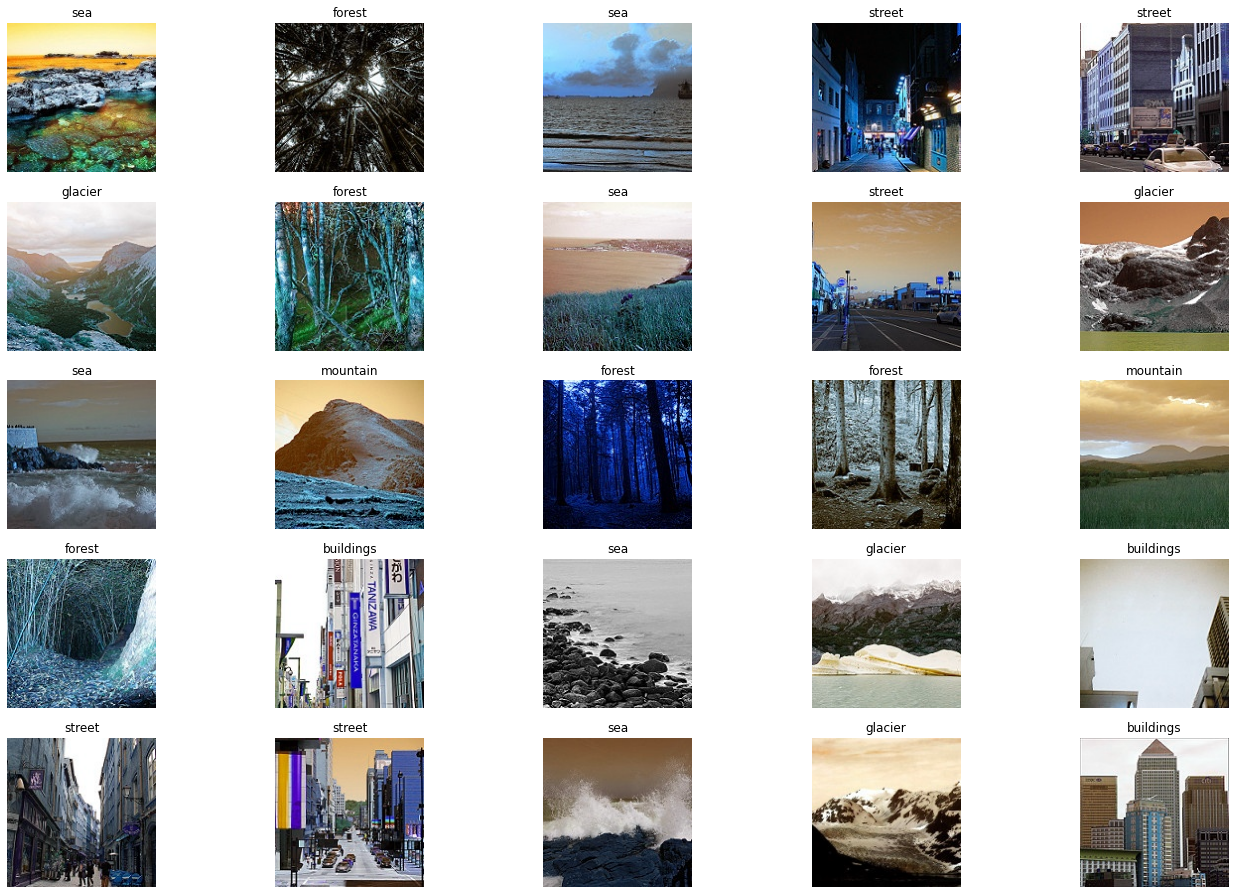

In [10]:
#This function generate images
import matplotlib.pyplot as plot
from random import randint
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(TrainImages))
        ax[i,j].imshow(TrainImages[rnd_number])
        ax[i,j].set_title(get_classlabel(TrainLabels[rnd_number]))
        ax[i,j].axis('off')


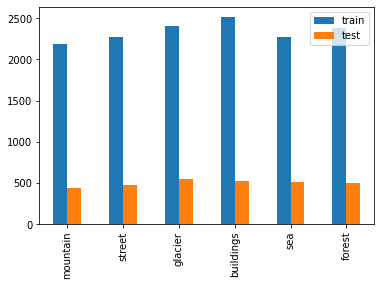

In [11]:
#Getting some sense of the data and comparing the ratio of the testset comparing to the trainingset by categories
import pandas as pd
La = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
_, train_counts = np.unique(TrainLabels, return_counts=True)
_, test_counts = np.unique(TestLabels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=La
            ).plot.bar()
plt.show()

In [ ]:
# I am working with keras so I dongraded to keras 1.14 so I benefit from the use of some functions that are no longer supported on tensoflow 2..0
!pip install tensorflow

In [12]:
# We use VGG16 that is previously trained on the imageNet dataset .
from tensorflow import keras 
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


IMG_SIZE=[224,224]  # VGG16 work with dataset with 224,224 dimensions

vgg=VGG16(input_shape= IMG_SIZE+[3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable=False


58900480/58889256 [==============================] - 0s 0us/step


In [13]:
# The architecture of the vgg16 neural network
x=Flatten()(vgg.output)
prediction=Dense(len(train_imgs), activation='softmax')(x)
model=Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) 

In [15]:
# Impleting Date augmentation to prevent overfitting
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip= True)
test_datagen=ImageDataGenerator(rescale=1./255)

training_set= train_datagen.flow_from_directory('seg_train/seg_train', target_size=(224,224), batch_size=32, class_mode='categorical')
test_set= test_datagen.flow_from_directory('seg_test/seg_test', target_size=(224,224), batch_size=32, class_mode='categorical')


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [16]:
#@title 
# Training the model
r=model.fit_generator(training_set, validation_data=test_set, epochs= 4, steps_per_epoch=len(training_set), validation_steps=len(test_set)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/4
439/439 [==============================] - 3328s 8s/step - loss: 0.5111 - accuracy: 0.8243 - val_loss: 0.4129 - val_accuracy: 0.8580
Epoch 2/4
439/439 [==============================] - 3274s 7s/step - loss: 0.3704 - accuracy: 0.8758 - val_loss: 0.3556 - val_accuracy: 0.8897
Epoch 3/4
439/439 [==============================] - 3271s 7s/step - loss: 0.3481 - accuracy: 0.8853 - val_loss: 0.4174 - val_accuracy: 0.8717
Epoch 4/4
439/439 [==============================] - 3268s 7s/step - loss: 0.2878 - accuracy: 0.9022 - val_loss: 0.3895 - val_accuracy: 0.8830


In [22]:
predictions_valid = model.predict(test_set, batch_size=32, verbose=1)


94/94 [==============================] - 569s 6s/step


In [ ]:
from sklearn.metrics import log_loss
score = log_loss(TrainLabels, predictions_valid)

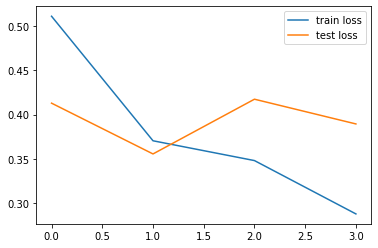

<Figure size 432x288 with 0 Axes>

In [25]:
#losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

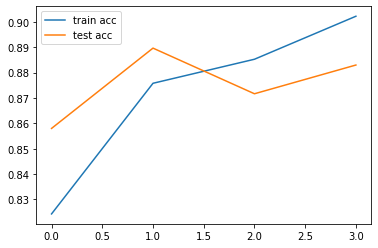

<Figure size 432x288 with 0 Axes>

In [26]:
#Plotting the accuracy over the number of epochs
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')